In [2]:
import cv2
import mediapipe as mp
import torch
import torchvision
import numpy as np
import pandas as pd
from torchvision.transforms import functional as F
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import os

In [3]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
SELECTED_LANDMARKS = {
    "LEFT_SHOULDER": mp_pose.PoseLandmark.LEFT_SHOULDER,
    "LEFT_ELBOW": mp_pose.PoseLandmark.LEFT_ELBOW,
    "LEFT_WRIST": mp_pose.PoseLandmark.LEFT_WRIST,
    "LEFT_HIP": mp_pose.PoseLandmark.LEFT_HIP,
    "LEFT_KNEE": mp_pose.PoseLandmark.LEFT_KNEE,
    "LEFT_ANKLE": mp_pose.PoseLandmark.LEFT_ANKLE,
}

# Initialize Keypoint R-CNN
model_rcnn = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
model_rcnn.eval()
device = torch.device("cpu")
model_rcnn.to(device)
COCO_KEYPOINTS = {
    "LEFT_SHOULDER": 5,
    "LEFT_ELBOW": 7,
    "LEFT_WRIST": 9,
    "LEFT_HIP": 11,
    "LEFT_KNEE": 13,
    "LEFT_ANKLE": 15,
}

EDGES = [
    ("LEFT_SHOULDER", "LEFT_ELBOW"),
    ("LEFT_ELBOW", "LEFT_WRIST"),
    ("LEFT_SHOULDER", "LEFT_HIP"),
    ("LEFT_HIP", "LEFT_KNEE"),
    ("LEFT_KNEE", "LEFT_ANKLE"),
]

# Default weights (balanced for most keypoints)
KEYPOINT_WEIGHTS_DEFAULT = {
    "LEFT_SHOULDER": {"mediapipe": 0.4, "rcnn": 0.6},
    "LEFT_ELBOW": {"mediapipe": 0.5, "rcnn": 0.5},
    "LEFT_WRIST": {"mediapipe": 0.3, "rcnn": 0.7},
    "LEFT_HIP": {"mediapipe": 0.4, "rcnn": 0.6},
    "LEFT_KNEE": {"mediapipe": 0.5, "rcnn": 0.5},
    "LEFT_ANKLE": {"mediapipe": 0.3, "rcnn": 0.7},
}

# Weights for cycling posture (favor R-CNN for knee)
KEYPOINT_WEIGHTS_CYCLING = {
    "LEFT_SHOULDER": {"mediapipe": 0.4, "rcnn": 0.6},
    "LEFT_ELBOW": {"mediapipe": 0.5, "rcnn": 0.5},
    "LEFT_WRIST": {"mediapipe": 0.3, "rcnn": 0.7},
    "LEFT_HIP": {"mediapipe": 0.4, "rcnn": 0.6},
    "LEFT_KNEE": {"mediapipe": 0.3, "rcnn": 0.7},
    "LEFT_ANKLE": {"mediapipe": 0.3, "rcnn": 0.7},
}

c:\Users\Habeeba\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Habeeba\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def get_mediapipe_keypoints(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    normalized_keypoints = {}
    
    with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
        results = pose.process(image_rgb)
        if results.pose_landmarks:
            height, width, _ = image.shape
            for name, landmark_enum in SELECTED_LANDMARKS.items():
                landmark = results.pose_landmarks.landmark[landmark_enum]
                normalized_keypoints[name] = (landmark.x, landmark.y, landmark.visibility)
    return normalized_keypoints

def get_rcnn_keypoints(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = F.to_tensor(image_rgb).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model_rcnn(image_tensor)
    keypoints = outputs[0]["keypoints"].cpu().numpy()
    scores = outputs[0]["scores"].cpu().numpy()
    keypoints = keypoints[scores > 0.5]
    
    if keypoints.shape[0] == 0:
        return {}
    
    height, width = image.shape[:2]
    selected_keypoints = {}
    for name, index in COCO_KEYPOINTS.items():
        x, y, conf = keypoints[0][index]
        x_normalized = x / width
        y_normalized = y / height
        selected_keypoints[name] = (x_normalized, y_normalized, conf)
    return selected_keypoints

def compute_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def compute_angle(p1, p2, p3):
    v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
    v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    return np.degrees(np.arccos(cos_angle))

def is_cycling_pose(keypoints):
    if ("LEFT_SHOULDER" in keypoints and "LEFT_HIP" in keypoints and 
        "LEFT_KNEE" in keypoints and "LEFT_ANKLE" in keypoints):
        shoulder_y = keypoints["LEFT_SHOULDER"][1]
        hip_y = keypoints["LEFT_HIP"][1]
        knee_y = keypoints["LEFT_KNEE"][1]
        ankle_y = keypoints["LEFT_ANKLE"][1]
        shoulder_conf = keypoints["LEFT_SHOULDER"][2]
        hip_conf = keypoints["LEFT_HIP"][2]
        knee_conf = keypoints["LEFT_KNEE"][2]
        ankle_conf = keypoints["LEFT_ANKLE"][2]
        
        if shoulder_conf > 0.6 and hip_conf > 0.6 and knee_conf > 0.6 and ankle_conf > 0.6:
            torso_lean = abs(shoulder_y - hip_y)
            knee_angle = compute_angle(
                (keypoints["LEFT_HIP"][0], keypoints["LEFT_HIP"][1]),
                (keypoints["LEFT_KNEE"][0], keypoints["LEFT_KNEE"][1]),
                (keypoints["LEFT_ANKLE"][0], keypoints["LEFT_ANKLE"][1])
            )
            if torso_lean < 0.3 and 30 < knee_angle < 150:
                return True
    return False

def check_anatomical_violation(key, x, y, keypoints):
    penalty = 0.0
    
    if key == "LEFT_WRIST" and "LEFT_SHOULDER" in keypoints and keypoints["LEFT_SHOULDER"][2] > 0.6:
        shoulder_y = keypoints["LEFT_SHOULDER"][1]
        if y < shoulder_y - 0.05:
            penalty += 0.3
    
    if key == "LEFT_KNEE" and "LEFT_HIP" in keypoints and "LEFT_ANKLE" in keypoints:
        hip_y = keypoints["LEFT_HIP"][1]
        ankle_y = keypoints["LEFT_ANKLE"][1]
        hip_conf = keypoints["LEFT_HIP"][2]
        ankle_conf = keypoints["LEFT_ANKLE"][2]
        
        if y < hip_y - 0.05 and hip_conf > 0.6:
            penalty += 0.2
        
        if hip_conf > 0.6 and ankle_conf > 0.6:
            hip_x, hip_y, _ = keypoints["LEFT_HIP"]
            ankle_x, ankle_y, _ = keypoints["LEFT_ANKLE"]
            angle = compute_angle((hip_x, hip_y), (x, y), (ankle_x, ankle_y))
            if angle < 20 or angle > 170:
                penalty += 0.2
                print(f"Knee angle warning: {angle:.2f} degrees (extreme angle detected).")
    
    if key == "LEFT_ANKLE" and "LEFT_KNEE" in keypoints and keypoints["LEFT_KNEE"][2] > 0.6:
        knee_y = keypoints["LEFT_KNEE"][1]
        if y < knee_y - 0.05:
            penalty += 0.3
    
    if key == "LEFT_SHOULDER" and "LEFT_HIP" in keypoints and keypoints["LEFT_HIP"][2] > 0.6:
        hip_y = keypoints["LEFT_HIP"][1]
        if y > hip_y + 0.05:
            penalty += 0.3
    
    return penalty

def evaluate_keypoint_consistency(key, keypoints, other_keypoints, edges):
    x, y, conf = keypoints[key]
    if conf <= 0.5:
        return 0.0
    
    neighbors = []
    for k1, k2 in edges:
        if k1 == key and k2 in keypoints and keypoints[k2][2] > 0.5:
            neighbors.append(k2)
        elif k2 == key and k1 in keypoints and keypoints[k1][2] > 0.5:
            neighbors.append(k1)
    
    if not neighbors:
        return conf * (1.0 - check_anatomical_violation(key, x, y, keypoints))
    
    consistency_score = 0.0
    count = 0
    for neighbor in neighbors:
        if neighbor in other_keypoints and other_keypoints[neighbor][2] > 0.5:
            my_x, my_y, _ = keypoints[key]
            my_neighbor_x, my_neighbor_y, _ = keypoints[neighbor]
            other_x, other_y, _ = other_keypoints[key]
            other_neighbor_x, other_neighbor_y, _ = other_keypoints[neighbor]
            
            my_dx = my_x - my_neighbor_x
            my_dy = my_y - my_neighbor_y
            other_dx = other_x - other_neighbor_x
            other_dy = other_y - other_neighbor_y
            
            my_dist = compute_distance((my_x, my_y), (my_neighbor_x, my_neighbor_y)) + 1e-6
            other_dist = compute_distance((other_x, other_y), (other_neighbor_x, other_neighbor_y)) + 1e-6
            my_dx_norm = my_dx / my_dist
            my_dy_norm = my_dy / my_dist
            other_dx_norm = other_dx / other_dist
            other_dy_norm = other_dy / other_dist
            
            similarity = 1.0 - 0.5 * (abs(my_dx_norm - other_dx_norm) + abs(my_dy_norm - other_dy_norm))
            consistency_score += similarity
            count += 1
    
    if count > 0:
        consistency_score /= count
        anatomical_penalty = check_anatomical_violation(key, x, y, keypoints)
        consistency_score *= (1.0 - anatomical_penalty)
        return 0.3 * consistency_score + 0.7 * conf
    return conf * (1.0 - check_anatomical_violation(key, x, y, keypoints))

def fuse_keypoints_selective(mediapipe_kps, rcnn_kps, edges):
    is_cycling = is_cycling_pose(mediapipe_kps)
    KEYPOINT_WEIGHTS = KEYPOINT_WEIGHTS_CYCLING if is_cycling else KEYPOINT_WEIGHTS_DEFAULT
    print(f"Pose classified as {'cycling' if is_cycling else 'non-cycling'}. Using weights: {KEYPOINT_WEIGHTS}")
    
    fused_keypoints = {}
    
    for key in SELECTED_LANDMARKS.keys():
        mp_kp = mediapipe_kps.get(key, (0.0, 0.0, 0.0))
        rcnn_kp = rcnn_kps.get(key, (0.0, 0.0, 0.0))
        
        mp_x, mp_y, mp_conf = mp_kp
        rcnn_x, rcnn_y, rcnn_conf = rcnn_kp
        
        mp_consistency = evaluate_keypoint_consistency(key, mediapipe_kps, rcnn_kps, edges) if mp_conf > 0 else 0.0
        rcnn_consistency = evaluate_keypoint_consistency(key, rcnn_kps, mediapipe_kps, edges) if rcnn_conf > 0 else 0.0
        
        print(f"{key} - MediaPipe Consistency: {mp_consistency:.2f}, R-CNN Consistency: {rcnn_consistency:.2f}")
        
        mp_weight = KEYPOINT_WEIGHTS[key]["mediapipe"]
        rcnn_weight = KEYPOINT_WEIGHTS[key]["rcnn"]
        mp_adjusted = mp_consistency * mp_weight
        rcnn_adjusted = rcnn_consistency * rcnn_weight
        
        if mp_adjusted > rcnn_adjusted + 0.1:
            fused_x, fused_y, fused_conf = mp_x, mp_y, mp_conf
            print(f"{key}: Using MediaPipe prediction.")
        elif rcnn_adjusted > mp_adjusted + 0.1:
            fused_x, fused_y, fused_conf = rcnn_x, rcnn_y, rcnn_conf
            print(f"{key}: Using R-CNN prediction.")
        elif mp_conf > 0 and rcnn_conf > 0:
            total_weight = mp_weight + rcnn_weight
            mp_fusion_weight = mp_weight / total_weight
            rcnn_fusion_weight = rcnn_weight / total_weight
            fused_x = mp_fusion_weight * mp_x + rcnn_fusion_weight * rcnn_x
            fused_y = mp_fusion_weight * mp_y + rcnn_fusion_weight * rcnn_y
            fused_conf = max(mp_conf, rcnn_conf)
            print(f"{key}: Using weighted averaging with weights (MP: {mp_fusion_weight:.2f}, R-CNN: {rcnn_fusion_weight:.2f}).")
        elif mp_conf > 0:
            fused_x, fused_y, fused_conf = mp_x, mp_y, mp_conf
            print(f"{key}: Using MediaPipe prediction (R-CNN unavailable).")
        elif rcnn_conf > 0:
            fused_x, fused_y, fused_conf = rcnn_x, rcnn_y, rcnn_conf
            print(f"{key}: Using R-CNN prediction (MediaPipe unavailable).")
        else:
            fused_x, fused_y, fused_conf = 0.0, 0.0, 0.0
            print(f"{key}: No reliable prediction available.")
        
        fused_keypoints[key] = (fused_x, fused_y, fused_conf)
    
    return fused_keypoints

def fallback_and_correct(fused_kps, mediapipe_kps, rcnn_kps, edges):
    adjusted_kps = fused_kps.copy()
    
    for key in adjusted_kps.keys():
        x, y, conf = adjusted_kps[key]
        if conf <= 0.5:
            neighbors = []
            for k1, k2 in edges:
                if k1 == key and k2 in adjusted_kps and adjusted_kps[k2][2] > 0.5:
                    neighbors.append((k2, adjusted_kps[k2]))
                elif k2 == key and k1 in adjusted_kps and adjusted_kps[k1][2] > 0.5:
                    neighbors.append((k1, adjusted_kps[k1]))
            
            if neighbors:
                total_conf = sum(n_conf for _, (_, _, n_conf) in neighbors)
                if total_conf > 0:
                    avg_x = sum(nx * n_conf for _, (nx, _, n_conf) in neighbors) / total_conf
                    avg_y = sum(ny * n_conf for _, (_, ny, n_conf) in neighbors) / total_conf
                    adjusted_kps[key] = (avg_x, avg_y, 0.5)
                    print(f"{key}: Estimated position using neighbors.")
    
    if "LEFT_SHOULDER" in adjusted_kps and "LEFT_HIP" in adjusted_kps:
        shoulder_y = adjusted_kps["LEFT_SHOULDER"][1]
        hip_y = adjusted_kps["LEFT_HIP"][1]
        shoulder_conf = adjusted_kps["LEFT_SHOULDER"][2]
        hip_conf = adjusted_kps["LEFT_HIP"][2]
        if shoulder_y > hip_y + 0.05 and shoulder_conf > 0.6 and hip_conf > 0.6:
            adjusted_kps["LEFT_SHOULDER"] = (adjusted_kps["LEFT_SHOULDER"][0], hip_y - 0.05, shoulder_conf * 0.9)
            print("Corrected LEFT_SHOULDER position (was below hip).")
    
    if "LEFT_SHOULDER" in adjusted_kps and "LEFT_WRIST" in adjusted_kps:
        shoulder_y = adjusted_kps["LEFT_SHOULDER"][1]
        wrist_y = adjusted_kps["LEFT_WRIST"][1]
        wrist_conf = adjusted_kps["LEFT_WRIST"][2]
        if wrist_y < shoulder_y - 0.05 and wrist_conf > 0.6:
            adjusted_kps["LEFT_WRIST"] = (adjusted_kps["LEFT_WRIST"][0], shoulder_y, wrist_conf * 0.8)
            print("Corrected LEFT_WRIST position (was above shoulder).")
    
    if "LEFT_HIP" in adjusted_kps and "LEFT_KNEE" in adjusted_kps:
        hip_y = adjusted_kps["LEFT_HIP"][1]
        knee_y = adjusted_kps["LEFT_KNEE"][1]
        knee_conf = adjusted_kps["LEFT_KNEE"][2]
        if knee_y < hip_y - 0.05 and knee_conf > 0.6:
            corrected_y = hip_y - 0.02
            blended_y = 0.7 * knee_y + 0.3 * corrected_y
            adjusted_kps["LEFT_KNEE"] = (adjusted_kps["LEFT_KNEE"][0], blended_y, knee_conf * 0.9)
            print("Soft-corrected LEFT_KNEE position (was too far above hip).")
    
    if "LEFT_KNEE" in adjusted_kps and "LEFT_ANKLE" in adjusted_kps:
        knee_y = adjusted_kps["LEFT_KNEE"][1]
        ankle_y = adjusted_kps["LEFT_ANKLE"][1]
        ankle_conf = adjusted_kps["LEFT_ANKLE"][2]
        if ankle_y < knee_y - 0.05 and ankle_conf > 0.6:
            corrected_y = knee_y + 0.02
            blended_y = 0.7 * ankle_y + 0.3 * corrected_y
            adjusted_kps["LEFT_ANKLE"] = (adjusted_kps["LEFT_ANKLE"][0], blended_y, ankle_conf * 0.8)
            print("Soft-corrected LEFT_ANKLE position (was too far above knee).")
    
    return adjusted_kps

In [5]:
def calculate_angle(p1, p2, p3):
    v1 = np.array([p1[0] - p2[0], p1[1] - p2[1]])
    v2 = np.array([p3[0] - p2[0], p3[1] - p2[1]])
    dot_product = np.dot(v1, v2)
    mag_v1 = np.linalg.norm(v1)
    mag_v2 = np.linalg.norm(v2)
    
    if mag_v1 == 0 or mag_v2 == 0:
        return np.nan
    
    cos_theta = dot_product / (mag_v1 * mag_v2)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    angle_rad = np.arccos(cos_theta)
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

def calculate_angles_from_keypoints(fused_keypoints):
    # Elbow angle: shoulder -> elbow -> wrist
    shoulder = (fused_keypoints["LEFT_SHOULDER"][0], fused_keypoints["LEFT_SHOULDER"][1])
    elbow = (fused_keypoints["LEFT_ELBOW"][0], fused_keypoints["LEFT_ELBOW"][1])
    wrist = (fused_keypoints["LEFT_WRIST"][0], fused_keypoints["LEFT_WRIST"][1])
    elbow_angle = calculate_angle(shoulder, elbow, wrist)
    
    # Hip angle: shoulder -> hip -> knee
    hip = (fused_keypoints["LEFT_HIP"][0], fused_keypoints["LEFT_HIP"][1])
    knee = (fused_keypoints["LEFT_KNEE"][0], fused_keypoints["LEFT_KNEE"][1])
    hip_angle = calculate_angle(shoulder, hip, knee)
    
    # Knee angle: hip -> knee -> ankle
    ankle = (fused_keypoints["LEFT_ANKLE"][0], fused_keypoints["LEFT_ANKLE"][1])
    knee_angle = calculate_angle(hip, knee, ankle)
    
    return elbow_angle, hip_angle, knee_angle

Class weights: {0: 1.0, 2: 1.0, 1: 1.0036764705882353}

Training on fold 1...

Classification Report for Fold 1:


,precision,recall,f1-score,support
High Risk,1.0,1.0,1.0,55.0
Low Risk,1.0,1.0,1.0,54.0
No Risk,1.0,1.0,1.0,55.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,164.0
weighted avg,1.0,1.0,1.0,164.0


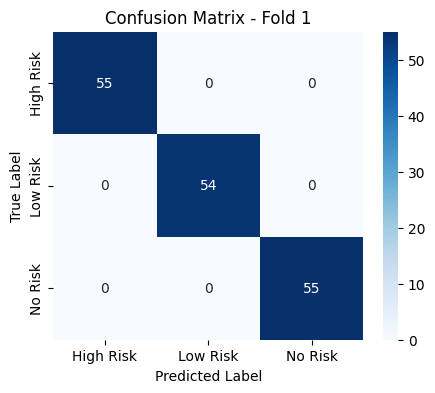


Training on fold 2...

Classification Report for Fold 2:


,precision,recall,f1-score,support
High Risk,0.962963,0.945455,0.954128,55.000000
Low Risk,0.932203,1.000000,0.964912,55.000000
No Risk,1.000000,0.944444,0.971429,54.000000
accuracy,0.963415,0.963415,0.963415,0.963415
macro avg,0.965055,0.963300,0.963490,164.000000
weighted avg,0.964842,0.963415,0.963441,164.000000


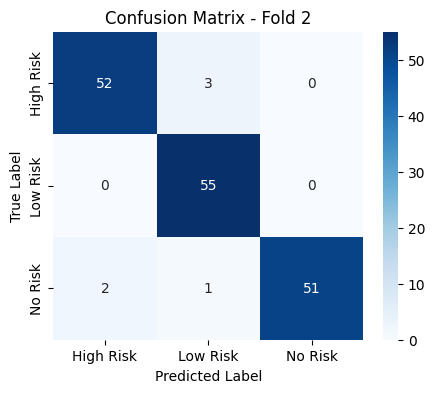


Training on fold 3...

Classification Report for Fold 3:


,precision,recall,f1-score,support
High Risk,1.000000,0.890909,0.942308,55.000000
Low Risk,0.916667,1.000000,0.956522,55.000000
No Risk,0.981818,1.000000,0.990826,54.000000
accuracy,0.963415,0.963415,0.963415,0.963415
macro avg,0.966162,0.963636,0.963218,164.000000
weighted avg,0.966066,0.963415,0.963050,164.000000


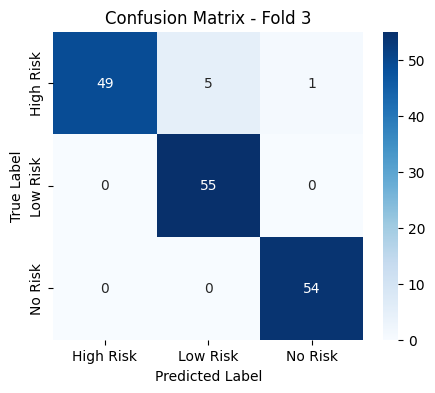


Training on fold 4...

Classification Report for Fold 4:


,precision,recall,f1-score,support
High Risk,0.947368,1.000000,0.972973,54.000000
Low Risk,1.000000,0.944444,0.971429,54.000000
No Risk,1.000000,1.000000,1.000000,55.000000
accuracy,0.981595,0.981595,0.981595,0.981595
macro avg,0.982456,0.981481,0.981467,163.000000
weighted avg,0.982564,0.981595,0.981581,163.000000


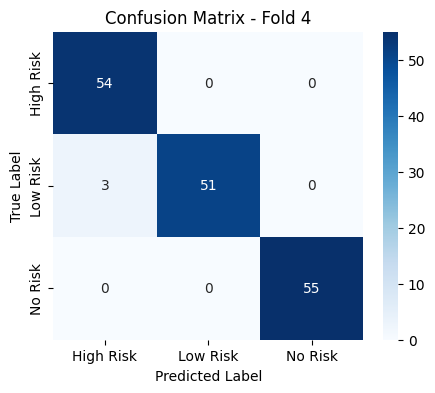


Training on fold 5...

Classification Report for Fold 5:


,precision,recall,f1-score,support
High Risk,0.964286,1.000000,0.981818,54.00000
Low Risk,1.000000,0.944444,0.971429,54.00000
No Risk,0.964286,0.981818,0.972973,55.00000
accuracy,0.975460,0.975460,0.975460,0.97546
macro avg,0.976190,0.975421,0.975407,163.00000
weighted avg,0.976117,0.975460,0.975392,163.00000


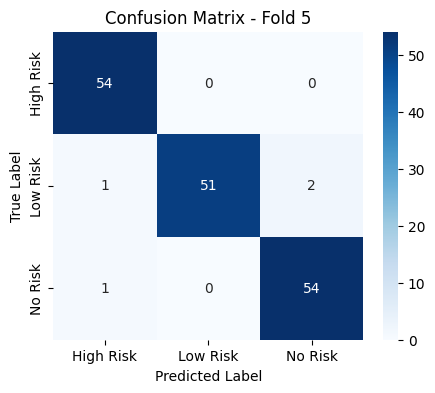


Average Classification Report Across All Folds:
------------------------------------------------


,precision,recall,f1-score,support
High Risk,0.974923,0.967273,0.970245,273.0
Low Risk,0.969774,0.977778,0.972858,272.0
No Risk,0.989221,0.985253,0.987045,273.0
macro avg,0.977973,0.976768,0.976716,818.0
weighted avg,0.977918,0.976777,0.976693,818.0



Overall Model Accuracy Across All Folds: 0.9768


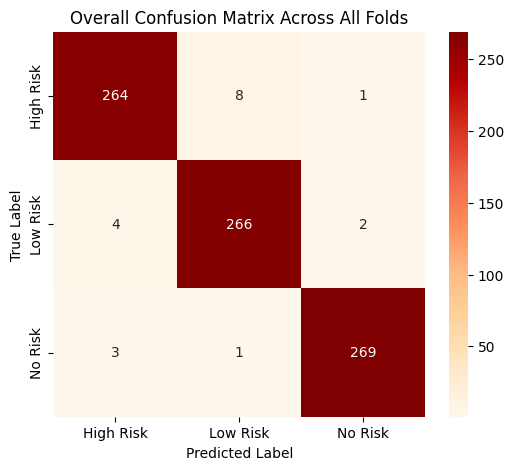

Final model trained on the entire dataset for deployment.


In [6]:
from IPython.display import display  
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training dataset
df = pd.read_excel(r"C:\PJT2\Orbbec_Dataset_New\Orbbec_Dataset\Dataset\CHECK DATASET\checkdataset_2video_classified_balanceddataset.xlsx")

# Features and target
X = df[["left_elbow_angle", "left_hip_angle", "left_knee_angle"]]
y = df["risk_level"]

# Encode the target variable (Low Risk, No Risk, High Risk) as numerical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Calculate class weights to handle imbalance
class_counts = pd.Series(y_encoded).value_counts()
class_weights = {i: max(class_counts) / count for i, count in class_counts.items()}
print("Class weights:", class_weights)

# Create sample weights for training based on class weights
sample_weights = np.array([class_weights[label] for label in y_encoded])

# Initialize StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store metrics for each fold
fold_reports = []
accuracies = []
conf_matrices = []

# Perform k-fold cross-validation
fold_num = 1
for train_index, val_index in skf.split(X, y_encoded):
    print(f"\nTraining on fold {fold_num}...")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]
    sample_weights_train = sample_weights[train_index]

    xgb_model = XGBClassifier(
        objective="multi:softmax",
        num_class=3,
        eval_metric="mlogloss",
        random_state=42
    )
    xgb_model.fit(X_train, y_train, sample_weight=sample_weights_train)

    y_pred = xgb_model.predict(X_val)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    y_val_labels = label_encoder.inverse_transform(y_val)

    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

    print(f"\nClassification Report for Fold {fold_num}:")
    report = classification_report(y_val_labels, y_pred_labels, target_names=label_encoder.classes_, output_dict=True)
    display(pd.DataFrame(report).T)
    
    fold_reports.append(report)

    # Compute and store confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    conf_matrices.append(cm)

    # Plot confusion matrix for the current fold
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - Fold {fold_num}")
    plt.show()

    fold_num += 1

# Compute average metrics across all folds
avg_report = {}
for label in label_encoder.classes_:
    avg_report[label] = {
        "precision": np.mean([fold_reports[i][label]["precision"] for i in range(len(fold_reports))]),
        "recall": np.mean([fold_reports[i][label]["recall"] for i in range(len(fold_reports))]),
        "f1-score": np.mean([fold_reports[i][label]["f1-score"] for i in range(len(fold_reports))]),
        "support": np.sum([fold_reports[i][label]["support"] for i in range(len(fold_reports))])
    }

avg_report["macro avg"] = {
    "precision": np.mean([fold_reports[i]["macro avg"]["precision"] for i in range(len(fold_reports))]),
    "recall": np.mean([fold_reports[i]["macro avg"]["recall"] for i in range(len(fold_reports))]),
    "f1-score": np.mean([fold_reports[i]["macro avg"]["f1-score"] for i in range(len(fold_reports))]),
    "support": np.sum([fold_reports[i]["macro avg"]["support"] for i in range(len(fold_reports))])
}

avg_report["weighted avg"] = {
    "precision": np.mean([fold_reports[i]["weighted avg"]["precision"] for i in range(len(fold_reports))]),
    "recall": np.mean([fold_reports[i]["weighted avg"]["recall"] for i in range(len(fold_reports))]),
    "f1-score": np.mean([fold_reports[i]["weighted avg"]["f1-score"] for i in range(len(fold_reports))]),
    "support": np.sum([fold_reports[i]["weighted avg"]["support"] for i in range(len(fold_reports))])
}

print("\nAverage Classification Report Across All Folds:")
print("------------------------------------------------")
avg_report_df = pd.DataFrame(avg_report).T
display(avg_report_df)

# Compute and print overall model accuracy
overall_accuracy = np.mean(accuracies)
print(f"\nOverall Model Accuracy Across All Folds: {overall_accuracy:.4f}")

# Compute and display overall confusion matrix
overall_cm = np.sum(conf_matrices, axis=0)
plt.figure(figsize=(6, 5))
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='OrRd', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Overall Confusion Matrix Across All Folds")
plt.show()

# Train the final model on the entire dataset
final_model = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42
)
final_model.fit(X, y_encoded, sample_weight=sample_weights)
print("Final model trained on the entire dataset for deployment.")

In [7]:
def predict_risk_level(image_path, model, label_encoder, output_image_path=None):
    """
    Predict the risk level for a single image by detecting keypoints, calculating angles,
    and using the trained XGBoost model.
    
    Parameters:
    - image_path (str): Path to the input image.
    - model (XGBClassifier): Trained XGBoost model.
    - label_encoder (LabelEncoder): Label encoder used to encode/decode risk levels.
    - output_image_path (str, optional): Path to save the annotated image with keypoints.
    
    Returns:
    - predicted_label (str): Predicted risk level ("High Risk", "Low Risk", "No Risk").
    - angles (tuple): Calculated angles (elbow_angle, hip_angle, knee_angle).
    """
    print(f"\nProcessing image: {image_path}...")
    
    # Step 1: Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}")
    
    # Step 2: Detect keypoints using MediaPipe and Keypoint R-CNN
    mediapipe_kps = get_mediapipe_keypoints(image_path)
    rcnn_kps = get_rcnn_keypoints(image_path)
    
    print("\nMediaPipe Keypoints:")
    for name, (x, y, conf) in mediapipe_kps.items():
        print(f"{name}: (x={x:.5f}, y={y:.5f}, confidence={conf:.2f})")
    print("\nR-CNN Keypoints:")
    for name, (x, y, conf) in rcnn_kps.items():
        print(f"{name}: (x={x:.5f}, y={y:.5f}, confidence={conf:.2f})")
    
    # Step 3: Fuse keypoints
    fused_keypoints = fuse_keypoints_selective(mediapipe_kps, rcnn_kps, EDGES)
    fused_keypoints = fallback_and_correct(fused_keypoints, mediapipe_kps, rcnn_kps, EDGES)
    
    print("\nFused Keypoints:")
    for name, (x, y, conf) in fused_keypoints.items():
        print(f"{name}: (x={x:.5f}, y={y:.5f}, confidence={conf:.2f})")
    
    # Step 4: Calculate angles
    elbow_angle, hip_angle, knee_angle = calculate_angles_from_keypoints(fused_keypoints)
    
    print(f"\nCalculated Angles:")
    print(f"Left Elbow Angle: {elbow_angle:.2f} degrees")
    print(f"Left Hip Angle: {hip_angle:.2f} degrees")
    print(f"Left Knee Angle: {knee_angle:.2f} degrees")
    
    # Check for invalid angles
    if np.isnan(elbow_angle) or np.isnan(hip_angle) or np.isnan(knee_angle):
        raise ValueError("One or more angles could not be calculated (NaN). Check keypoint detection.")
    
    # Step 5: Prepare input for the model
    angles_df = pd.DataFrame([[elbow_angle, hip_angle, knee_angle]], 
                             columns=["left_elbow_angle", "left_hip_angle", "left_knee_angle"])
    
    # Step 6: Predict the risk level
    y_pred = model.predict(angles_df)
    predicted_label = label_encoder.inverse_transform(y_pred)[0]
    
    print(f"\nPredicted Risk Level: {predicted_label}")
    
    # Step 7: Optionally draw and save the annotated image
    if output_image_path:
        def draw_fused_keypoints(image, keypoints):
            height, width = image.shape[:2]
            
            # Dynamically scale based on image height
            scale_factor = height / 480  # Reference height
            font_scale_small = 0.5 * scale_factor
            font_scale_large = 1.0 * scale_factor
            thickness_small = max(1, int(1 * scale_factor))
            thickness_large = max(2, int(2 * scale_factor))
            circle_radius = max(3, int(5 * scale_factor))

            # Draw keypoints and labels
            for name, (x_norm, y_norm, conf) in keypoints.items():
                if conf > 0.5:
                    x_pixel, y_pixel = int(x_norm * width), int(y_norm * height)
                    cv2.circle(image, (x_pixel, y_pixel), circle_radius, (255, 0, 0), -1)
                    coord_text = f"{name}: ({x_norm:.5f}, {y_norm:.5f})"
                    cv2.putText(image, coord_text, (x_pixel + 10, y_pixel - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, font_scale_small, (255, 0, 0), thickness_small)

            # Add risk level at top-left
            text = f"Risk Level: {predicted_label}"
            (text_width, text_height), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale_large, thickness_large)
            y_position = text_height + 10
            x_position = 10
            cv2.putText(image, text, (x_position, y_position),
                        cv2.FONT_HERSHEY_SIMPLEX, font_scale_large, (1, 255, 2), thickness_large)
            return image  # return modified image

        # Draw and save the annotated image
        annotated_image = draw_fused_keypoints(image.copy(), fused_keypoints)
        cv2.imwrite(output_image_path, annotated_image)
        print(f"Saved annotated image to: {output_image_path}")

    return predicted_label, (elbow_angle, hip_angle, knee_angle)

In [10]:
# Example usage of the predict_risk_level function
image_path = r"C:\PJT2\Orbbec_Dataset_New\Orbbec_Dataset\Dataset\sample_images\2out_of_range_highrisk4.png"# Replace with your image path
output_image_path = r"C:\PJT2\Orbbec_Dataset_New\Orbbec_Dataset\Dataset\sample_images_output\2out_of_range_highrisk4_op.png" # Replace with desired output path

try:
    predicted_label, angles = predict_risk_level(
        image_path=image_path,
        model=final_model,
        label_encoder=label_encoder,
        output_image_path=output_image_path
    )
    print(f"\nFinal Results for {image_path}:")
    print(f"Predicted Risk Level: {predicted_label}")
    print(f"Angles - Elbow: {angles[0]:.2f}, Hip: {angles[1]:.2f}, Knee: {angles[2]:.2f}")
except Exception as e:
    print(f"Error processing image: {e}")


Processing image: C:\PJT2\Orbbec_Dataset_New\Orbbec_Dataset\Dataset\sample_images\2out_of_range_highrisk4.png...

MediaPipe Keypoints:
LEFT_SHOULDER: (x=0.33904, y=0.17769, confidence=1.00)
LEFT_ELBOW: (x=0.40106, y=0.35886, confidence=0.96)
LEFT_WRIST: (x=0.25710, y=0.39805, confidence=0.98)
LEFT_HIP: (x=0.59775, y=0.21127, confidence=1.00)
LEFT_KNEE: (x=0.42239, y=0.36539, confidence=0.98)
LEFT_ANKLE: (x=0.56850, y=0.50347, confidence=0.91)

R-CNN Keypoints:
LEFT_SHOULDER: (x=0.34193, y=0.17329, confidence=1.00)
LEFT_ELBOW: (x=0.40693, y=0.34578, confidence=1.00)
LEFT_WRIST: (x=0.28505, y=0.39953, confidence=1.00)
LEFT_HIP: (x=0.60500, y=0.21078, confidence=1.00)
LEFT_KNEE: (x=0.42928, y=0.37328, confidence=1.00)
LEFT_ANKLE: (x=0.59281, y=0.52577, confidence=1.00)
Pose classified as cycling. Using weights: {'LEFT_SHOULDER': {'mediapipe': 0.4, 'rcnn': 0.6}, 'LEFT_ELBOW': {'mediapipe': 0.5, 'rcnn': 0.5}, 'LEFT_WRIST': {'mediapipe': 0.3, 'rcnn': 0.7}, 'LEFT_HIP': {'mediapipe': 0.4, 'rc